### YouTube Agent with OpenAI and lang graph

**Resources**
- [YouTube video](https://youtu.be/-BUs1CPHKfU)
- [Blog post](https://medium.com/@shawhin/how-to-improve-llms-with-tools-69cc68c804ed?sk=3ffd8308ce4905617b136a02cfa8dd83)

### imports

In [1]:
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api.proxies import WebshareProxyConfig
import re
from agents import Agent, function_tool, Runner
from openai.types.responses import ResponseTextDeltaEvent
from dotenv import load_dotenv
from langchain_community.llms import Ollama
from langchain.agents import initialize_agent, AgentType
from typing import Literal, Annotated, Literal, Optional, TypedDict, Any
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph
from langchain_core.tools import tool as tool



import os
import asyncio
import operator
from langgraph.graph import END, START, StateGraph
from langgraph.types import Send
from pydantic import BaseModel, Field

In [2]:
import logging
# Suppress httpx INFO logs to reduce console output
logging.getLogger("httpx").setLevel(logging.WARNING)

In [3]:
load_dotenv("../.env")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY_PERSONAL")

In [4]:
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [5]:
class State(TypedDict):
    input: str
    content: str
    content_summary: str

In [6]:
# 3. Pure functional YouTube transcript tool
def fetch_youtube_transcript(url: str) -> str:
    """
    Extract transcript with timestamps from a YouTube video URL and format it for LLM consumption.
    Args:
        url (str): YouTube video URL
    Returns:
        str: Formatted transcript with timestamps, each entry on a new line as "[MM:SS] Text"
    """
   
    def extract_video_id(url: str) -> str:
        video_id_pattern = r'(?:v=|\/)([0-9A-Za-z_-]{11}).*'
        video_id_match = re.search(video_id_pattern, url)
        if not video_id_match:
            raise ValueError("Invalid YouTube URL")
        return video_id_match.group(1)

    def format_entry(entry: Any) -> str:
        # Try attribute access, fallback to dict-style if needed
        start = getattr(entry, 'start', None)
        text = getattr(entry, 'text', None)
        if start is None or text is None:
            # fallback to dict-style (for older API versions)
            start = entry['start']
            text = entry['text']
        return f"[{int(start//60):02d}:{int(start%60):02d}] {text}"

    video_id = extract_video_id(url)
    ytt_api = YouTubeTranscriptApi(
        proxy_config=WebshareProxyConfig(
            proxy_username=os.getenv("WEBSHARE_PROXY_USERNAME"),
            proxy_password=os.getenv("WEBSHARE_PROXY_PASSWORD"),
            filter_ip_locations=["us"],
        )
    )
    # all requests done by ytt_api will now be proxied through Webshare
    transcript = ytt_api.fetch(video_id=video_id, languages=['en', 'ta'])
    # without any proxy (ip blocked!)
    #transcript = YouTubeTranscriptApi().fetch(video_id=video_id, languages=['en', 'ta'])

    formatted_entries = list(map(format_entry, transcript))
    return "\n".join(formatted_entries)

In [7]:
def get_url(_: str = None) -> State:
    """
    Waits for user input to get the YouTube URL.
    Returns a State dict with the input URL or 'quit' if the user wants to exit.
    """
    url = input("Please enter a YouTube video URL (or type 'quit' to exit): ").strip()
    if not url or url.lower() in ("end", "quit", "exit"):
        return {"input": "quit"}
    return {"input": url}


def extract_transcript(state: State) -> str:
    """
    Extract transcript with timestamps from a YouTube video URL and format it for LLM consumption
    
    Args:
        state(State): State object containing the input URL
        
    Returns:
        str: Formatted transcript with timestamps, where each entry is on a new line
             in the format: "[MM:SS] Text"
    """

    tube_contents = fetch_youtube_transcript(state["input"]) 
    
    return {"content": tube_contents}


def extract_transcript_llm_is_unable_to_extract(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert at getting the transcript of a youtube video. Given a youtube video url, you will extract the transcript and return it in a structured format."
        ),
        HumanMessage(
            content=f"The input URL is:\n\n {state['input']}"
        ),
    ]
    return {"content": model.invoke(messages).content}
    
    
def generate_transcript_summary(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert summarizer of any given content. Provided with a content extracted from a youtube video,\
                you will summarize the data and make it less than 500 characters and also provide the timestamp of the content."
        ),
        HumanMessage(
            content=f"The input content is:\n\n {state['content']}"
        ),
    ]
    return {"content_summary": model.invoke(messages).content}


def check_to_exit_loop(state: State) -> str:
    if state["input"] is None or len(state["input"]) == 0 or (state["input"] in ("quit")):
        return "end"
    return "continue"


In [8]:
workflow_builder = StateGraph(State)

#workflow_builder.add_node("get_url", get_url)
workflow_builder.add_node("extract_transcript", extract_transcript)
workflow_builder.add_node("generate_transcript_summary", generate_transcript_summary)

workflow_builder.add_edge(START, "extract_transcript")
workflow_builder.add_edge("extract_transcript", "generate_transcript_summary")
#workflow_builder.add_conditional_edges(
#    source = "get_url",
#    path = check_to_exit_loop,
#    path_map = {
#        "end": END,
#        "continue": "extract_transcript",
#    },
#)
#workflow_builder.add_edge("generate_transcript_summary", "get_url")

workflow = workflow_builder.compile()

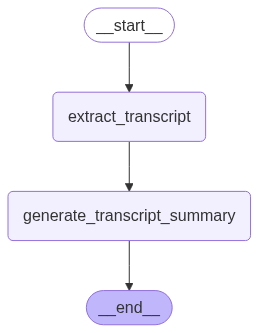

In [9]:
display(Image(workflow.get_graph().draw_mermaid_png()))

#### Test now

* what is this video about? ``https://youtu.be/ZaY5_ScmiFE``

* what is this video about? ``https://www.youtube.com/watch?v=bCVsI1q5dxY&list=PL1NtlG9_mds6gV80fZ-5WcjQrvM0TEnlc``

In [10]:
youtube_summary = workflow.invoke({"input": "https://youtu.be/ZaY5_ScmiFE"})

RequestBlocked: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=ZaY5_ScmiFE! This is most likely caused by:

YouTube is blocking your requests, despite you using Webshare proxies. Please make sure that you have purchased "Residential" proxies and NOT "Proxy Server" or "Static Residential", as those won't work as reliably! The free tier also uses "Proxy Server" and will NOT work!

The only reliable option is using "Residential" proxies (not "Static Residential"), as this allows you to rotate through a pool of over 30M IPs, which means you will always find an IP that hasn't been blocked by YouTube yet!

You can support the development of this open source project by making your Webshare purchases through this affiliate link: https://www.webshare.io/?referral_code=w0xno53eb50g 

Thank you for your support! <3

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!

In [ ]:
youtube_summary